In [146]:
import sys, os
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import seaborn as sns
import scipy
%matplotlib inline
results_path = 'Results/'

In [23]:
# Load all tests
all_tests = [i for i in os.listdir(results_path)]
if '.ipynb_checkpoints' in all_tests:
    all_tests.remove('.ipynb_checkpoints')
all_tests = [int(i) for i in all_tests]
all_tests

[1, 10, 11, 12, 13, 2, 3, 4, 5, 7, 8, 9]

In [24]:
def get_data(rock_id, seconds):
    ''' Returns array of temps @ given seconds'''
    
    assert seconds in [0, 10, 30]
    assert rock_id in all_tests
    
    path = results_path + str(rock_id)
    files= os.listdir(path)    
    for file in files:
        if "_"+str(seconds) in file:
            f = open(path + "/" + file, "rb") 
    return np.load(f)

In [375]:
def view(rock_id):
    z, t = get_data(rock_id, 0), get_data(rock_id, 10)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(z, linewidth=0, ax=ax1)
    sns.heatmap(t, linewidth=0, ax=ax2)
    fig.set_size_inches(15, 5)
    fig.show()

def view_img(img):
    sns.heatmap(img, linewidth=0)
    plt.show()

# Analyze

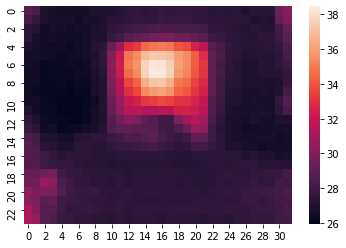

Cold


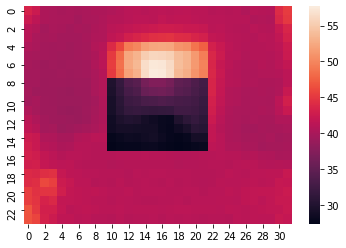

In [414]:
def clean_img(rock_id, seconds):
    
    im = get_data(rock_id, seconds)
    view_img(im)
    pixel_range = 5
    center_data, idx = crop(im, pixel_range, True, 1.2)
    center_mean = np.mean(center_data)
    
    if center_mean < np.mean(im) or len(np.where(im > np.mean(im))[0]) > 20:
        print("Cold")
        cold_rock = True
        hot_rock = False
    else:
        print("Hot")
        cold_rock = False
        hot_rock = True
   
    if cold_rock:
        for row in range(im.shape[0]):
            for col in range(im.shape[1]):
                if (row,col) not in idx:
                    im[row,col] *= 1.5
                    
#         im[im > np.mean(im) - 0.01*(im.max() - np.mean(im))] = im.mean()/1
#         cleaned = np.clip(im, im.min(), np.mean(im) + 0.1*(im.max() - np.mean(im)))
        
    else:
        # hot rock
        cleaned = np.clip(im, np.mean(im), im.max())
        
    view_img(im)

    return im

im = clean_img(4,10)

In [403]:
def crop(img, pixel_range = 5, get_i = False, ratio=1.1):
    x,y = img.shape
    mid_x, mid_y = int(x/2), int(y/2)
    row_indices = range(mid_x-int(pixel_range/ratio), mid_x+int(pixel_range/ratio))
    col_indices = range(mid_y-int(pixel_range*ratio), mid_y+int(pixel_range*ratio))
    cropped = []
    indx = []
    for row in row_indices:
        to_add = []
        cropped.append([])
        for col in col_indices:
            indx.append((row,col))
            to_add.append(img[row, col])
        cropped[-1] = np.array(to_add)
        
    if get_i:
        return np.array(cropped), indx

    return np.array(cropped)

def resize(img, factor):
    return cv.resize(img, dsize=(img.shape[1]*factor,img.shape[0]*factor), interpolation=cv.INTER_CUBIC)

In [356]:
def get_grad(img):
    x,y = np.gradient(img)
    return (x**2+y**2)**0.5

def remove_bg(img):
    x,y = img.shape
    points = [
        [int(i) for i in [x*0.2,y*0.2]],
        [int(i) for i in [x*0.8,y*0.2]],
        [int(i) for i in [x*0.2,y*0.3]],
        [int(i) for i in [x*0.8,y*0.3]],        
    ]
#     view_img(img)
    vals = np.array([img[p[0], p[1]] for p in points])
#     bg_val = np.mean(vals[:2])
    bg_val = vals.min()
#     img[img <= bg_val] = 0.0

#     view_img(np.clip(img, bg_val, img.max()))
    return np.clip(img, bg_val, img.max())

In [357]:
def view_two_im(im1, im2):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(im1, linewidth=0, ax=ax1)
    sns.heatmap(im2, linewidth=0, ax=ax2)
    fig.set_size_inches(10, 3)
    fig.show()

In [363]:
def get_mask(original_im, resize_factor):
    im = get_grad(original_im)
    im = 255*(im - np.min(im))/np.ptp(im) # normalize to rgb values
    im = remove_bg(im) # remove background noise
    im = im.astype(np.uint8)
    im = resize(im, resize_factor) # make bigger
    
#     print("Mid")
#     view_two_im(im, cv.bitwise_not(im))
    
    mask = cv.threshold(im, 0, 255, cv.THRESH_OTSU + cv.THRESH_BINARY)[1]
    mask = scipy.ndimage.morphology.binary_fill_holes(mask)
    return resize(original_im, resize_factor), mask

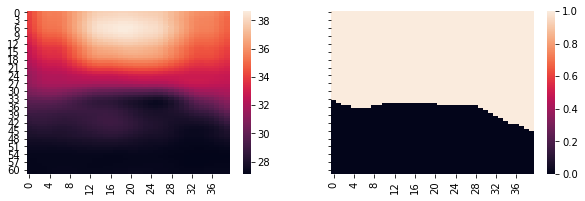

In [475]:
def process_img(rock_id, seconds, resize_factor = 5, plot=True):

    original_im = get_data(rock_id, seconds)
#     original_im = clean_img(rock_id, seconds)
    
    # reisizes orignal img and get a mask
    original_im, mask = get_mask(original_im, resize_factor)
    # Crop both
    original_im, mask = (crop(i, int(5*resize_factor), ratio=0.8) for i in [original_im, mask])
    
    if plot:
#         print(rock_id, seconds)
        view_two_im(original_im, mask)

    return original_im[mask]

masked = process_img(4, 10)

In [464]:
def process_manualy(im, top_left, bot_right, plot=True):
    cropped = im[top_left[0]:bot_right[0], top_left[1]:bot_right[1]]
#     cropped = resize(cropped, 5)
    
    if plot:
        view_img(im)
        view_img(cropped)
    
    return cropped

---

1 0 -4.988474950939636 13.663281835775244 27.110125618475557
1 10 25.643816995319444 28.22115752866993 31.858064557068996
2 0 0.8492323727634987 17.75076816116658 27.850556996491584
2 10 23.8637699749141 27.662468823100777 30.25774772331034
3 0 4.517869098101648 19.420994450292522 32.14947819921075
3 10 29.794584896190965 44.915189116807944 71.81672030162675
4 0 8.505186191340787 20.690038641940983 33.43580509816767
5 0 1.6142165340813777 17.679230863037272 29.76816449480863
5 10 24.395584927978945 26.827203294612612 29.34851672927967
7 0 5.4973131083496325 18.86785121098409 27.49357648770563
7 10 20.760744038161715 25.925669404779885 29.17253248714256
8 0 6.613005391163191 18.36827842310812 28.639003475533197
8 10 27.45906382402724 29.937189025494952 33.933892605386106
9 0 4.949739633200866 18.076315454850093 27.604777674423314
9 10 28.143980790389726 34.32434217759294 49.33981596145448
10 0 0.9665529654871823 15.738973333356672 26.971561988398246
10 10 16.381849437390375 24.840285396

/home/addy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


12 10 15.939120510560462 29.264167534916513 41.38122914045929
13 0 3.7274463417505066 16.921319405799125 26.739078617290048


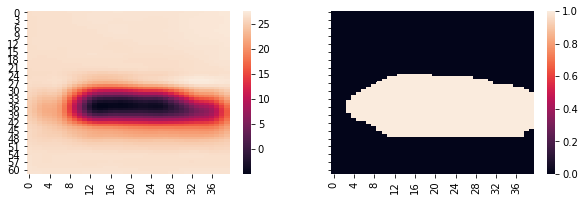

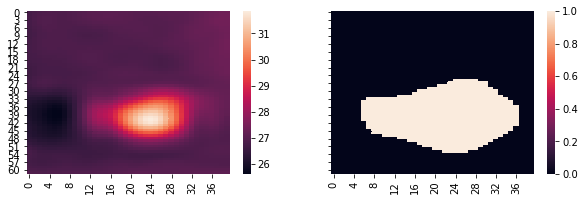

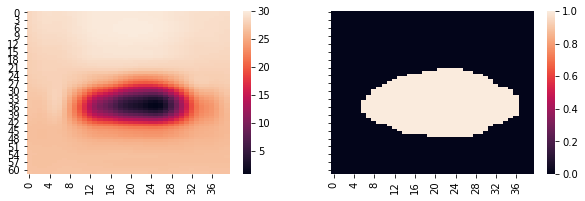

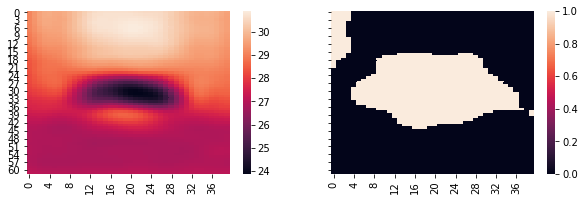

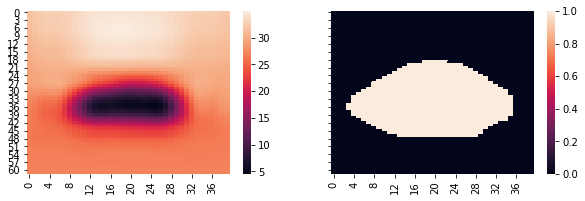

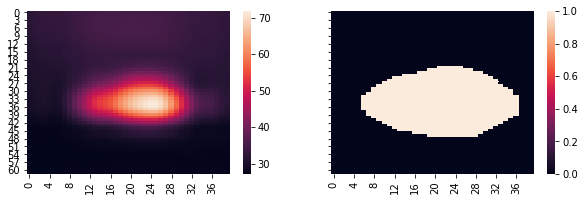

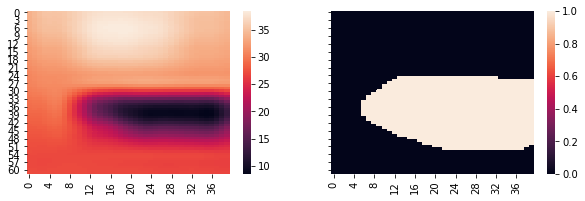

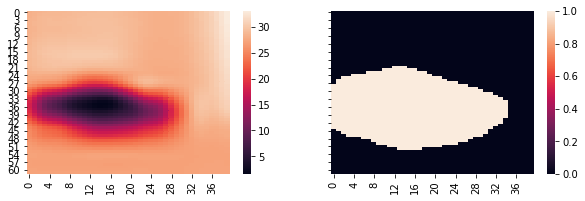

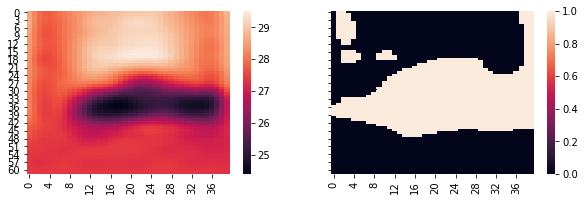

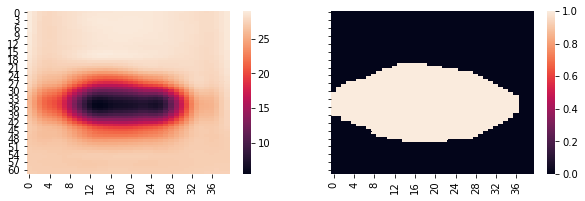

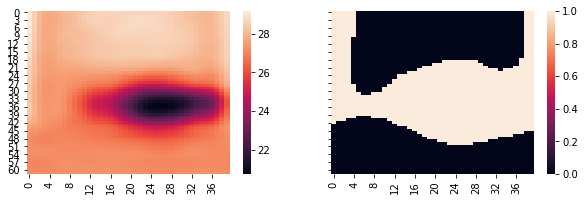

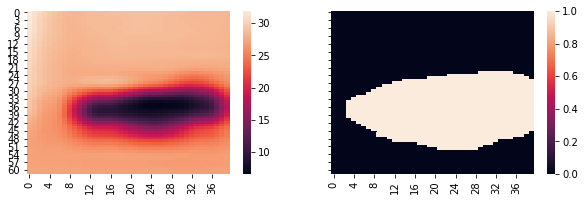

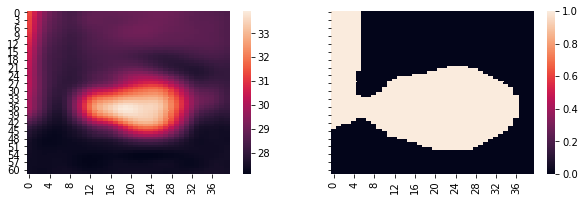

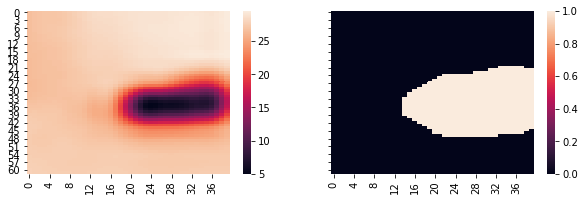

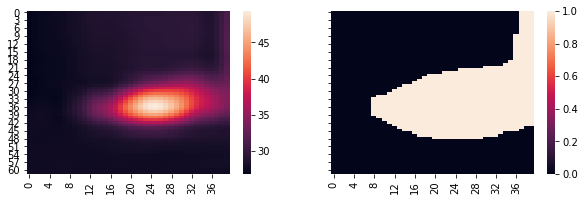

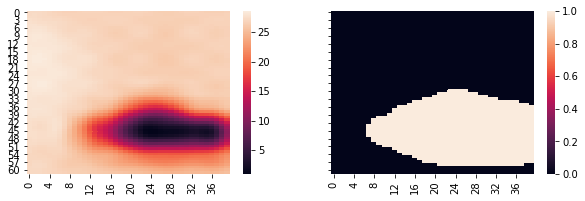

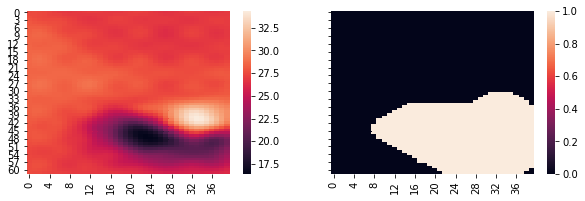

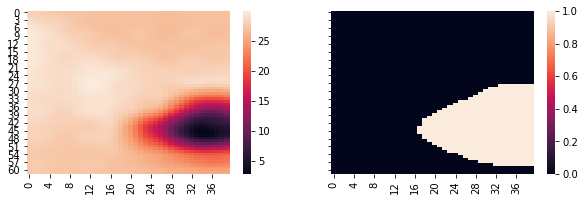

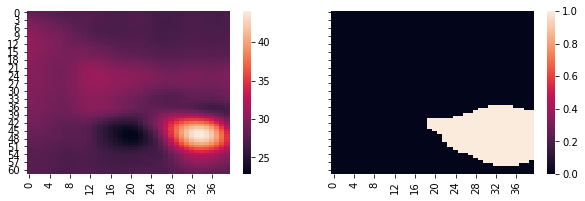

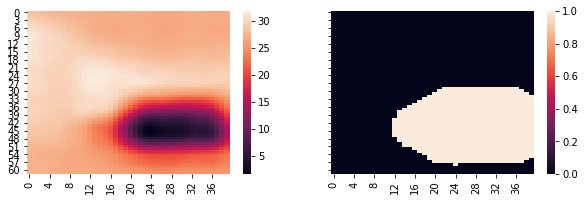

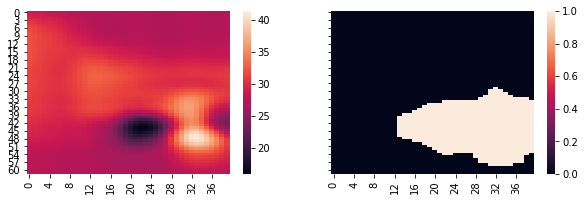

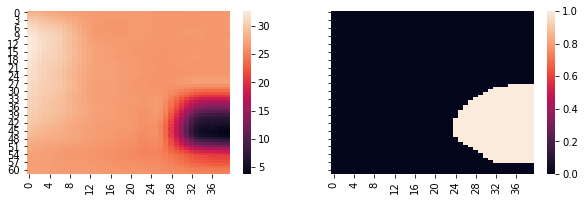

In [482]:
for test in sorted(all_tests):
    for s in [0, 10]:
        if (test,s) not in [(4,10), (13, 10)]:
            rock = process_img(test, s, plot=True)
            print(test, s, rock.min(), np.mean(rock), rock.max())

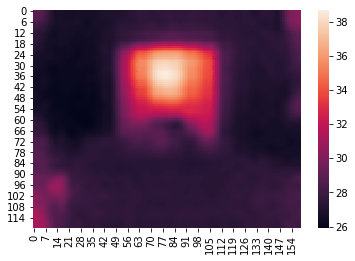

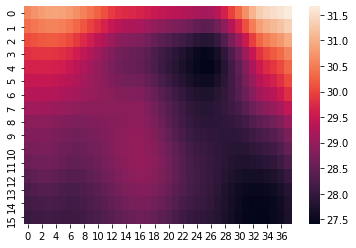

4 10 27.409900453823987 28.726721137217616 31.667615221937595


In [478]:
i=resize(get_data(4,10), 5)
rock=process_manualy(i, (60,60), (76, 98), plot=True)
print(4, 10, rock.min(), np.mean(rock), rock.max())

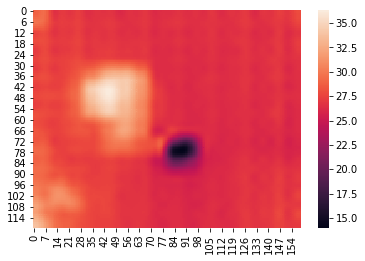

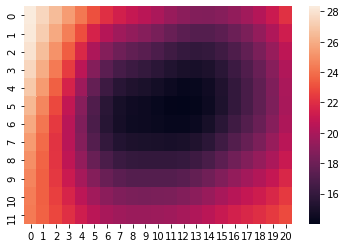

13 10 14.006045013563778 19.18527230919656 28.325893733887387


In [480]:
i=resize(get_data(13,10), 5)
# view_img(i)
rock=process_manualy(i, (72,77), (84, 98), plot=True)
print(13, 10, rock.min(), np.mean(rock), rock.max())